# BE/Bi 103, Fall 2015: Homework 3
## Due 1pm, Monday, October 19
*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw3_protected.ipynb).*

In [1]:
import glob
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special
import scipy.stats as st
import numdifftools as ndt

# Use Numba for speed
import numba

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches
import bokeh.io
import bokeh.models
import bokeh.plotting

# Utilities for BE/Bi 103
import bebi103

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 3.1: Detecting horizonatal gene transfer (50 pts)
You heard Griffin talk about his research during Tutorial 3.  Now is your chance to work with some of his data.  The data sets may be downloaded [here](http://bebi103.caltech.edu/2015/protected/data/chure.zip).  Be sure to read the header comments.

**a)** For each data set, compute the number of of transformed cells.  You will have to decide on a criterion for what constitutes a transformed cell.  Comment on how you decided on this criterion.

**b)** For each plasmid concentration, compute and plot the posterior distribution, $P(p\mid n_t, n, I)$, where $n_t$ out of $n$ cells are determined to have been transformed, and $p$ is the probability that any given cell is transformed.  Do this for both the anaerobic and aerobic data sets.

**c)** Show that the posterior distribution may be approximated as a Gaussian distribution with mean $p^* = n_t/n$ and variance

\begin{align}
\sigma^2 = \frac{(p^*)^2 (1 - p^*)^2}{n(p^*)^2 + n_t(1-2p^*)}.
\end{align}

Comment on any potential issues you see with this approximation.

**d)** Plot $p^*$ versus the plasmid concentration with error bars given by the values of $\sigma$ you calculated in part (c).  Think carefully about how you display this plot.

**e)** Griffin and I came up with a model to describe transformation.  We assumed that update of plasmic DNA is a Poisson process.  Therefore, the time $t$ required to take in a plasmid is exponentially distributed.

\begin{align}
P(t\mid r) = r\, \mathrm{e}^{-rt},
\end{align}

where $r$ is the rate of plasmid uptake.  We further assumed that $r$ is a linear function of the plasmid concentration, $c$, $r(c) = r_0c$.  Thus,

\begin{align}
P(t\mid r_0, c) = r_0 c \, \mathrm{e}^{-r_0 c t}.
\end{align}

The cells had plasmid available to them for a time $\tau = 1$ hour before washing out the plasmid DNA.  We assume that a cell that takes in at least one plasmid expresses YFP and will therefore be marked as transformed.  Therefore, the probability that a given cell took in no plasmids at all is

\begin{align}
P(\text{no plasmid}) = \int_\tau^\infty \mathrm{d}t\,P(t\mid r_0, c)
= \int_\tau^\infty \mathrm{d}t\,r_0 c \, \mathrm{e}^{-r_0 c t}
= \mathrm{e}^{-r_0 c \tau}.
\end{align}

Thus, the probability that a cell takes in at least one plasmid, which in our model is the probability that the cell is transformed, is 

\begin{align}
p = 1 - \mathrm{e}^{-r_0 c \tau}.
\end{align}

This is our theoretical model for $p$ as a function of the plasmid concentration.  We know $\tau = 1$ hour, so the parameter we are trying to fit is $r_0$, which describes the rate at which *Bacillus* is capable of taking in plasmid under aerobic or anaerobic conditions.

Find the most probable value of $r_0$ for the aerobic and for the anaerobic growth conditions, along with error bars.  Add the regression lines to the plot you made in part (d).  Comment on the results.  Are you satisfied with the proposed model?  Do you have any other suggestions?

*Hint*: For each plasmid concentration $c_i$, you computed $p_i^*$ and an error bar, $\sigma_i$.  Use these to construct your likelihood.  Since you have measured the $\sigma_i$'s, the only fit parameter is $r_0$.

### Problem 3.1: solution
**a)** Transformed cells have much higher fluorescence than the autofluorescence of untransformed cells.  The choice of what constitutes a transformed cell is somewhat arbitrary.  As a start, we should look at the data.  We will plot PDFs for the fluorescence intensity for each concentration of plasmids using KDE.

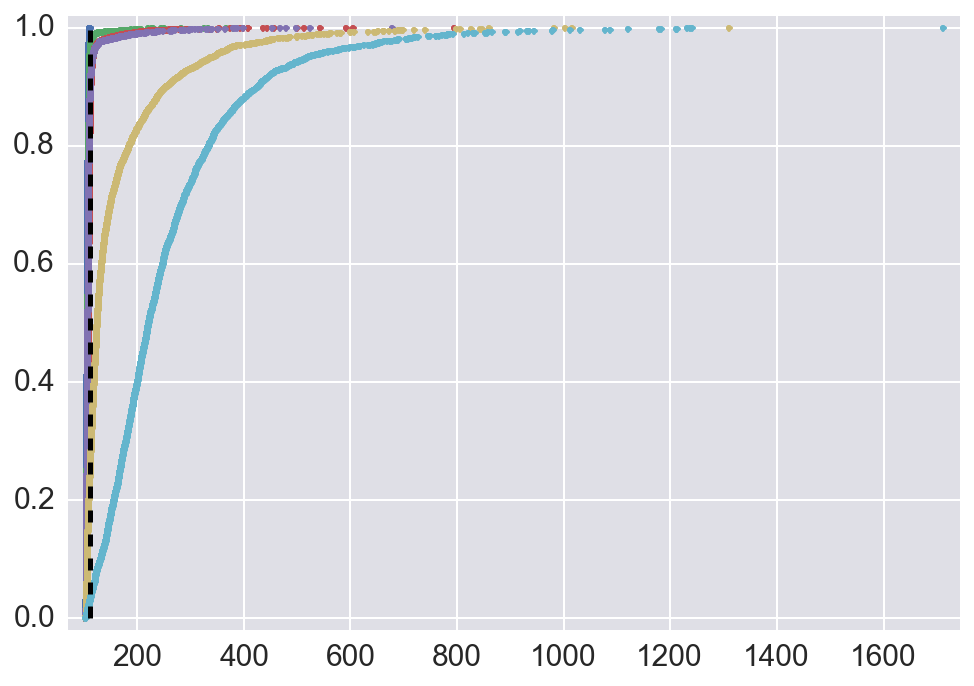

In [2]:
# Specify plasmids/cell
plas_per_cell = [0, 10, 100, 1000, 10000, 100000]

# Load DataFrames and tidy
df_ae = pd.read_csv('../data/chure/20151001_aerobic_mean_intensities.csv', 
                    comment='#')
df_ae.columns = plas_per_cell
df_ae = pd.melt(df_ae, var_name='plasmids/cell', value_name='mean fluor').dropna()

for i, p_conc in enumerate(df_ae['plasmids/cell'].unique()):
    inds = df_ae['plasmids/cell'] == p_conc
    y = np.arange(len(df_ae[inds])) / len(df_ae[inds])
    x = np.sort(df_ae[inds]['mean fluor'].values)
    if p_conc == 0:
        plt.plot([x.max(), x.max()], [0, 1], 'k--', zorder=2)
    plt.plot(x, y, '.', zorder=1)

plt.margins(0.02)

Here, the dashed line is the maximal concentration we see for the plasmid-free condition.  There is no obvious bimodality in the distributions (i.e., no background/signal separation), which suggests that transformants have a continuum of fluorescence signal.  We will therefore choose the maximum mean value of the autofluorescence signal as a cutoff when choosing whether or not a cell is transformed.

Once we can label each cell as transformed or not, we can compute the number of transformed cells.  Then, using the results that we will derive in part (c), we can compute the more probable values of $p$, the probability of transformation, and the standard in the parameter $p$, which we call $\sigma$.  We will store these results in a new `DataFrame`.

We write a function to do this analysis, and then apply it to the aerobic and anaerobic data sets.

In [3]:
def process_transformation_data(fname, plas_per_cell):
    """
    Read in a transformation data set and return summary statistics
    for each plasmid concentration.
    """
    # Load and tidy DataFram
    df = pd.read_csv(fname, comment='#')
    df.columns = plas_per_cell
    df = pd.melt(df, var_name='plasmids/cell', value_name='mean fluor').dropna()

    # Determine cutoff (5 stds out)
    cutoff = df[df['plasmids/cell'] == 0]['mean fluor'].max()
        
    # Number of fluorescent cells for each plasmid density
    df_n = pd.DataFrame(columns=['plasmids/cell', 'n_trans', 'n', 'p', 'sigma'])
    plas_dens = df['plasmids/cell'][df['plasmids/cell'] > 0].unique()
    for plas in plas_dens:
        n = (df['plasmids/cell'] == plas).sum()
        n_trans = ((df['plasmids/cell'] == plas) 
                           & (df['mean fluor'] > cutoff)).sum()
        p = n_trans / n
        sigma = np.sqrt(n_trans * (n - n_trans) / n**3)
        df_n = df_n.append(pd.DataFrame(
                np.array([[plas, n_trans, n, p, sigma]]), columns=df_n.columns),
                                            ignore_index=True)
    return df_n

df_ae = process_transformation_data(
    '../data/chure/20151001_aerobic_mean_intensities.csv', plas_per_cell)
df_an = process_transformation_data(
    '../data/chure/20151001_anaerobic_mean_intensities.csv', plas_per_cell)

We can inspect the `DataFrame`s to see the results.

In [4]:
print('Aerobic growth conditions\n-------------------------')
print(df_ae)

print('\n\nAnaerobic growth conditions\n---------------------------')
print(df_an)

Aerobic growth conditions
-------------------------
   plasmids/cell  n_trans      n         p     sigma
0             10      217   7451  0.029124  0.001948
1            100     1171  10731  0.109123  0.003010
2           1000      607   6907  0.087882  0.003407
3          10000     2473   3401  0.727139  0.007638
4         100000     2853   2952  0.966463  0.003314


Anaerobic growth conditions
---------------------------
   plasmids/cell  n_trans     n         p     sigma
0             10      144  9483  0.015185  0.001256
1            100      211  5157  0.040915  0.002758
2           1000     1581  4814  0.328417  0.006769
3          10000     1177  2798  0.420658  0.009333
4         100000      279   460  0.606522  0.022777


**b)** The posterior distribution is the same as the one we derived for Boolean data in [Tutorial 3b](http://bebi103.caltech.edu/2015/tutorials/t3b_boolean_data.html).

In [5]:
def log_posterior(k, n, p):
    """
    Log posterior of Boolean data with a Binomial likelihood.
    """
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(k + 1) \
              - scipy.special.gammaln(n - k + 1) \
              + k * np.log(p) + (n - k) * np.log(1 - p)

We can use this function to plot the posteriors.  We will use Seaborn's convenient paired palette to plot the aerobic and anaerobic posteriors on the same plot.  The aerobic posteriors are plotted in a dark color and the anaerobic posteriors in a lighter color.

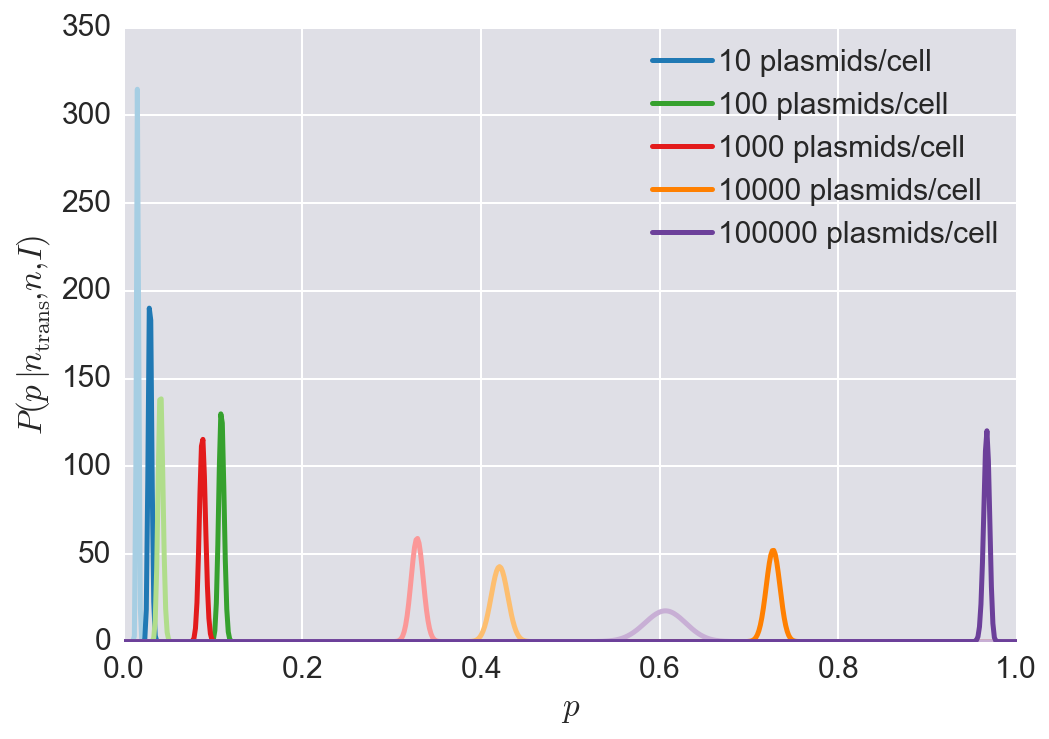

In [6]:
# Make smooth values of p
p = np.linspace(0, 1, 600)

# Specify color map
colors = sns.color_palette('Paired', 10)

# Array of lines that are plotted
lines = [None] * len(df_ae)

for i, c in enumerate(df_ae['plasmids/cell']):
    for j, df_ in enumerate([df_an, df_ae]):
        n_trans = df_[df_['plasmids/cell'] == c]['n_trans'].iloc[0]
        n = df_[df_['plasmids/cell'] == c]['n'].iloc[0]
        post = np.exp(log_posterior(n_trans, n, p))
        lines[i], = plt.plot(p, post, '-', color=colors[2*i+j])

# Label axes
plt.xlabel('$p$')
plt.ylabel(r'$P(p\mid n_\mathrm{trans}, n, I)$')

# Build legend
leg_strs = [str(int(c)) + ' plasmids/cell' for c in df_an['plasmids/cell']]
plt.legend(lines[:5], leg_strs, loc='upper right')

We see that, with the exception of the 1000 plasmids/cell concentration, the aerobic growth conditions lead to more effective transformation.

**c)** Recall that the posterior probability distribution is

\begin{align}
P(p \mid n_t, n, I) = \frac{(n+1)!}{n_t!\,(n-n_t)!}\,p^{n_t}\,(1-p)^{n-n_t}.
\end{align}

To compute the most probable value of $p$, $p^*$, we need to find where the first derivative of $P(p\mid n_t, n, I)$ vanishes.  This is equivalent to finding wehre the first derivative of $\ln P(p\mid n_t, n, I)$ vanishes.  We compute the first derivative

\begin{align}
\frac{\mathrm{d}\ln P}{\mathrm{d}p} = \frac{n_t}{p} - \frac{n-n_t}{1-p}.
\end{align}

Setting the first derivative equal to zero and solving for $p$ gives $p^* = n_t/n$.

To find the variance of the approximate Gaussian, we use the fact that

\begin{align}
\sigma^2 = -\left(\left.\frac{\mathrm{d}^2\ln P}{\mathrm{d}p^2}\right|_{p=p^*}\right)^{-1}.
\end{align}

We compute the second derivative as

\begin{align}
\frac{\mathrm{d}^2\ln P}{\mathrm{d}p^2} 
&= \frac{\mathrm{d}}{\mathrm{d}p}\left(\frac{n_t}{p} - \frac{n-n_t}{1-p}\right)
= -\frac{n_t}{p^2} - \frac{n-n_t}{(1-p)^2}
= -\frac{np^2 - n_t(1-2p)}{p^2 (1 - p)^2}.
\end{align}

Substituting $p^*$ for $p$, and taking the negative reciprocal gives the desired result,

\begin{align}
\sigma^2 = \frac{(p^*)^2 (1 - p^*)^2}{n(p^*)^2 - n_t(1-2p^*)}.
\end{align}

This can be further simplified, given that $p^* = n_t/n$ to

\begin{align}
\sigma^2 = \frac{n_t(n-n_t)}{n^3}.
\end{align}

We will use this as the error bar in our measurements, $p = p^* \pm \sigma$.

**d)** To make the plot, we could use Matploblib's `errorbar()` function, but the error bars are so small, they don't show up.

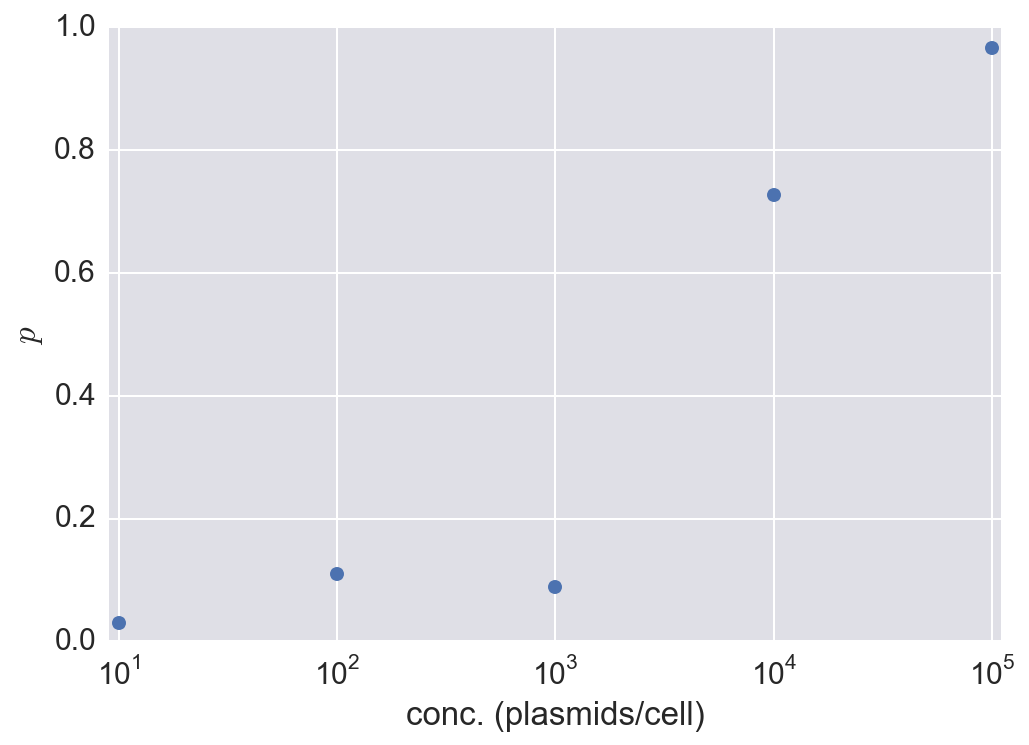

In [7]:
fig, ax = plt.subplots()
ax.errorbar(df_ae['plasmids/cell'], df_ae['p'], yerr=df_ae['sigma'],
            marker='o', linestyle='none')
ax.set_xscale("log", nonposx='clip')
ax.set_xlim((9, 110000))
ax.set_xlabel('conc. (plasmids/cell)')
ax.set_ylabel('$p$')

We therefore will not bother showing them.  We can plot the two conditions together.

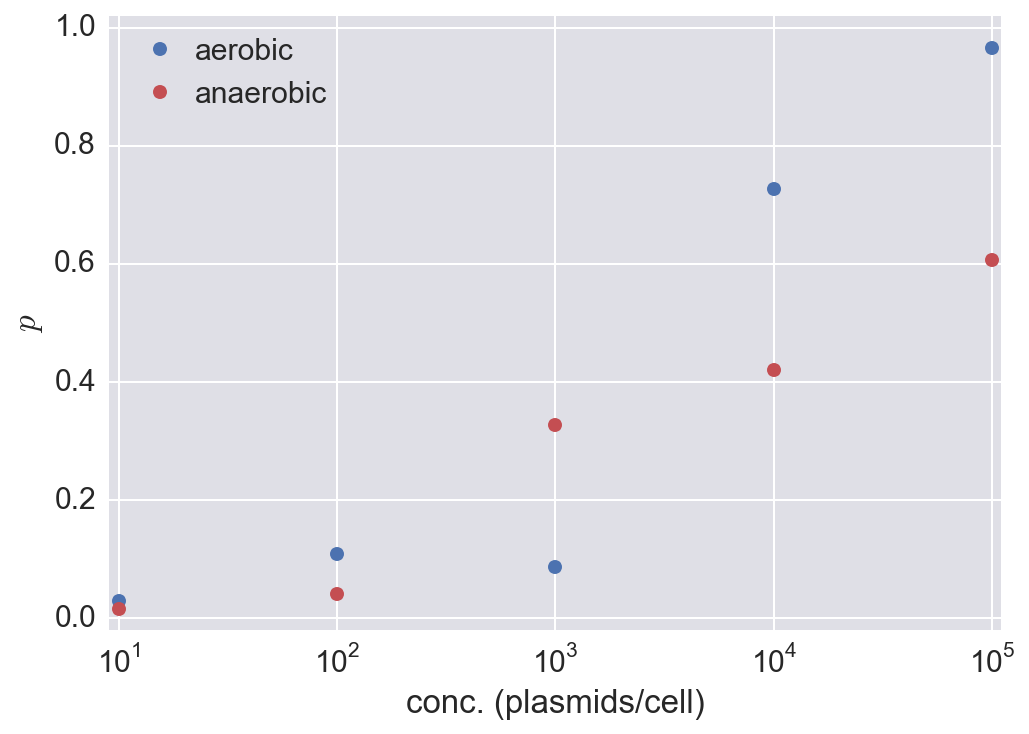

In [8]:
plt.semilogx(df_ae['plasmids/cell'], df_ae['p'], 'o')
plt.semilogx(df_an['plasmids/cell'], df_an['p'], 'o', 
             color=sns.color_palette()[2])
plt.xlim((9, 110000))
plt.ylim((-0.02, 1.02))
plt.xlabel('conc. (plasmids/cell)')
plt.ylabel('$p$')
plt.legend(('aerobic', 'anaerobic'), loc='upper left')

Note that we choose a logarithmic scale for the $x$-axis to be able to resolve all of the points.

**e)** To perform the regression, we start by defining our likelihood.  We assume that the theoretical model describes the data, and that the data are Gaussian distributed about the model.  Remember, in the context of this regression, the data are the concentration of plasmids, the probabilities of transformation, and the standard deviation of the probability.  Since $r_0$ and $\tau$ always appear as a product, we take $r_0\tau$ as a single parameter, knowing that $\tau = 1$ hour. The likelihood is then

\begin{align}
P(\left\{c_i, p_i, \sigma_i\right\}\mid r_0\tau, I) = \frac{1}{(2\pi)^{n/2}}\,\prod_i
\frac{1}{\sigma_i}\exp\left\{-\frac{\left(p_i - 1 + \mathrm{e}^{-r_0\tau c}\right)^2}{2\sigma_i}\right\}.
\end{align}

We could take a Jeffreys prior for $r_0\tau$, $P(r_0\tau \mid I) \propto 1/r_0\tau$.  This would reclude usage of least squares to do the curve fitting, and we will visit that in a moment.  For now, we will consider a uniform prior on $r_0\tau$.  Then, the posterior is

\begin{align}
P(r_0\tau\mid \left\{c_i, p_i, \sigma_i\right\}, I) \propto
\prod_i
\frac{1}{\sigma_i}\exp\left\{-\frac{\left(p_i - 1 + \mathrm{e}^{-r_0\tau c}\right)^2}{2\sigma_i}\right\}.
\end{align}

we first specify our theoretical and residual functions, along with the log of the posterior for this curve fitting problem.  The log posterior is

\begin{align}
\ln P(r_0\tau\mid \left\{c_i, p_i, \sigma_i\right\}, I) = \text{constant}
- \frac{1}{2}\sum_i \frac{\left(p_i - 1 + \mathrm{e}^{-r_0\tau c}\right)^2}{\sigma^2_i}.
\end{align}

We then directly use `scipy.optimize.leastsq()` to compute the most probable value of $r_0 \tau$ and use `numdifftools` to get the error bar.  There is a subtlety in this calculation.  Because $r_0 \tau$ is close to zero, and it is strictly positive, we need to take care to ensure that it is positive throughout the calculation.  We therefore take $\ln r_0\tau$ as our parameter.  Finding the most probable $\ln r_0\tau$ will enable us to trivially compute the most probable $r_0 \tau$.  To get the error bar, we note that, for any well-behaved function $f(x)$, 

\begin{align}
\frac{\mathrm{d}^2 f(\ln x)}{\mathrm{d}x^2} = \frac{1}{x^2}\left(
\frac{\mathrm{d}^2 f(\ln x)}{(\mathrm{d}\ln x)^2} - \left(\frac{\mathrm{d} f(\ln x)}{\mathrm{d}\ln x}\right)^2\right).
\end{align}

In our case, $f(x) = \ln P(r_0\tau\mid\left\{c_i, p_i, \sigma_i\right\}, I)$.  The first derivative vanishes at the more probable value, so to compute the error bar, we just compute the second derivative with the logarithm parameter and divide appropriately.  This is often a useful trick when doing parameter estimation by optimization.

In [9]:
def p_theor(log_r_0_tau, c):
    return 1 - np.exp(-np.exp(log_r_0_tau[0]) * c)

def resid(log_r_0_tau, c, p, sigma):
    return (p - p_theor(log_r_0_tau, c)) / sigma

def log_post_curvefit(log_r_0_tau, c, p, sigma):
    return -np.sum(resid(log_r_0_tau, c, p, sigma)**2) / 2

Now that we have defined our functions, we just plug and chug, exercising care when we compute the error bar.


    Aerobic
    -------
    r_0 τ = 122.9 ± 2.1  cells/plasmid * 1e6
    
    

    Anaerobic
    ---------
    r_0 τ = 74.4 ± 2.1  cells/plasmid * 1e6
    
    


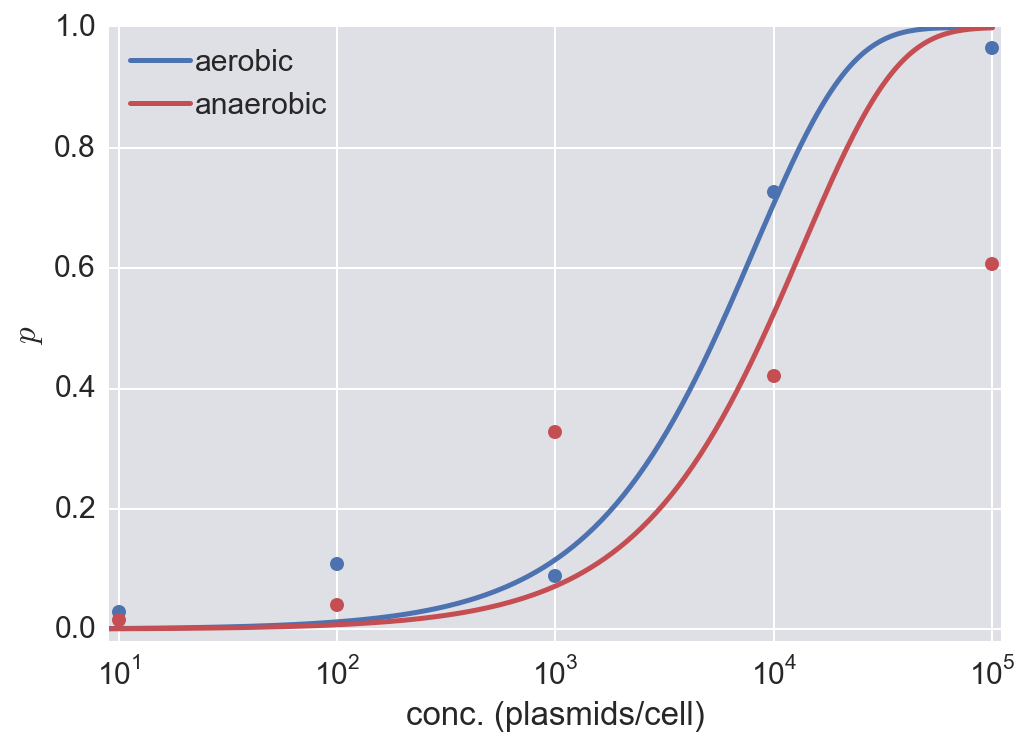

In [10]:
# Hessian function
hes_fun = ndt.Hessian(log_post_curvefit)

# Smooth plasmid concentrations for plotting
c_plot = np.logspace(0, 5, 300)

# Initial guess for least squares solve
r_0_tau0 = np.array([1e-4])

# Strings for displaying results
a_str = ['Aerobic\n    -------', 'Anaerobic\n    ---------']
    
# Perform regression for each
labels = ['aerobic', 'anaerobic']
for i, df_ in enumerate([df_ae, df_an]):
    args = (df_['plasmids/cell'], df_['p'], df_['sigma'])
    popt, _ = scipy.optimize.leastsq(resid, r_0_tau0, args=args)
    
    # Compute error bar
    err_bar = np.sqrt(-np.exp(popt[0])**2 / hes_fun(popt, *args)[0,0])

    # Plot results
    plt.semilogx(df_['plasmids/cell'], df_['p'], 'o', 
                 color=sns.color_palette()[i*2])
    plt.semilogx(c_plot, p_theor(popt, c_plot), '-',
                 color=sns.color_palette()[i*2], label=labels[i])
    
    # Print the results to the screen
    print("""
    {0:s}
    r_0 τ = {1:.1f} ± {2:.1f}  cells/plasmid * 1e6
    
    """.format(a_str[i], np.exp(popt[0]) * 1e6, err_bar * 1e6))

# Clean up plot
plt.xlim((9, 1.1e5))
plt.ylim((-0.02, 1.0))
plt.legend(loc='upper left')
plt.xlabel('conc. (plasmids/cell)')
plt.ylabel('$p$');

It appears as though the data point at $10^3$ plasmids/cell tugs extra hard on the anaerobic curve.  Further, the probability of transformation does not go as rapidly toward zero as we would expect at low plasmid concentrations, likely due to false positive identification of transformants.  I suspect that $r_0 \tau$ is overestimated for both curves.  This is in part because we only have five data points.  We don't really have enough data to refute the model, so we can't say right now if it is invalid.  We should perform more experiments to get more data!

<br />

### Problem 3.2: Dorsal gradients in *Drosophila* embryos (70 pts)
We will use a data set from [Angela Stathopoulos's lab](http://www.stathlab.caltech.edu), acquired to study morphogen profiles in developing fruit fly embryos.  The original paper is [Reeves, Trisnadi, et al., Dorsal-ventral gene expression
in the *Drosophila* embryo reflects the dynamics and precision of the Dorsal nuclear gradient, *Dev. Cell.*, **22**, 544-557, 2012](http://bebi103.caltech.edu/2015/protected/papers/reeves_2012.pdf), and the data set may be downloaded [here](http://bebi103.caltech.edu/2015/protected/data/reeves_et_al.zip).

In this experiment, Reeves, Trisnadi, and coworkers measured expression levels of a fusion of Dorsal, a morphogen transcription factor important in determining the dorsal-ventral axis of the developing organism, and Venus, a yellow fluorescent protein along the dorsal/ventral- (DV) coordinate.  They put this construct on the third chromosome, while the wild type *dorsal* is on the second.  Instead of the wild type, they had a homozygous *dorsal*-null mutant on the second chromosome.  The Dorsal-Venus construct rescues wild type behavior, so they could use this construct to study Dorsal gradients.

Dorsal shows higher expression on the ventral side of the organism, thus giving a *gradient* in expression from dorsal to ventral which can be ascertained by the spatial distribution of Venus fluorescence intensity.

This can be seen in the image below, which is a cross section of a fixed embryo with anti-Dorsal staining.  The bottom of the image is the ventral side and the top is the dorsal side of the embryo.  The DV coordinate system is defined by the yellow line.  It is periodic, going from $-1$ to $1$.  The DV-coordinate is therefore defined in relative terms around the embryo and is dimensionless.  The ventral nuclei show much higher expression of Dorsal.  The image is adapted from the Reeves, Trisnadi, et al. paper.

<img src="DV_coord.png">

*A quick note on nomenclature:* Dorsal (capital D) is the name of the protein product of the gene *dorsal* (italicized).  The dorsal (adjective) side of the embryo is its back.  The ventral side is its belly.  Dorsal is expressed more strongly on the ventral side of the developing embryo.  This can be confusing.

To quantify the gradient, Reeves, Trisnadi, and coworkers had to first choose a metric for describing it.  They chose to fit the measured profile of fluorescence intensity with a Gaussian (plus background) and use the standard deviation of that Gaussian as a metric for the width of the Dorsal gradient.  This provides a nice motivation for doing nonlinear regression.

Upon unzipping the data sets, you will find the file `reeves_dv_profile_over_time.csv`.  This contains the measured level of fluorescence intensity coming from the Dorsal-Venus construct at different stages of development.  Timing of development in the *Drosophila* embryo based on *nuclear cycles*, the number of nuclear divisions that have happened since fertilization.  Prior to cellularization of the syncytium, there are 14 rounds of nuclear division.  Reeves, Trisnadi, et al. measured Dorsal-Venus expression at nuclear cycle 11, 12, 13, and 14.

**a)** Comment on the choice of a Gaussian-plus-background function to fit the data.  Why do you think this was chosen?  Do you have other suggestions?

**b)** Write down expressions for the likelihood, prior, and posterior for a regression of this sort of data.  Be sure to explicitly state which assumptions go into these choices.

**c)** Perform regressions to quantify the width of the Dorsal-Venus gradient at each nuclear cycle.  Be sure to report error bars on the parameters you obtain.  You should also plot the gradient corresponding to the most probable parameter values along with the experimentally observed data points.

**d)** Reeves performed regressions like you have just done on many samples, including different methods of imaging.  These data are contained in the file `reeves_gradient_width_various_methods.csv`.  Be sure to read the comments describing the data.  Generate a plot summarizing these data.  Discuss your choice for how you chose to render your plot.  Based on what you see, is the Venus fusion a reasonable way to study the Dorsal gradient, as compared to the wild type cross-section gold standard?

### Problem 3.2: solution
**a)** To perform the regression, we of course need to know what model function to fit.  Reeves, et al. propsed using a Gaussian curve, plus background, to describe the profiles.  Strictly speaking, a Gaussian is not periodic, and these data are periodic, so we should fit a periodic function.  The periodic version of the Gaussian distribution is a Von Mises distribution,

\begin{align}
P(\theta~|~\mu,\beta) = \frac{\mathrm{e}^{\beta\cos(\theta - \mu)}}{2\pi I_0(\beta)},
\end{align}

where $\theta \in (0,2\pi]$ and $I_0(s)$ is a modified Bessel function.  The parameter $\beta$ is analogous to $1/\sigma^2$ in a Gaussian, and $\mu$ is of course analogous to $\mu$.  To use the Von Mises distribution to fit these data, we would make the change of variables $x = \theta/\pi - 1$ (where $x$ is the DV coordinate) giving

\begin{align}
P(x~|~\mu,\beta) = \frac{\mathrm{e}^{\beta\cos(\pi(x - \mu))}}{2 I_0(\beta)}.
\end{align}

However, because the Gaussian decays away far before the dorsal side, a Gaussian is for all purposes periodic.  In fact, when $\sigma$ is much smaller than the total domain size, the two distributions are almost the same, as we can see by plotting them.  This is also a nice time to bring up the useful distributions in the `scipy.stats` module (which I imported as `st`).

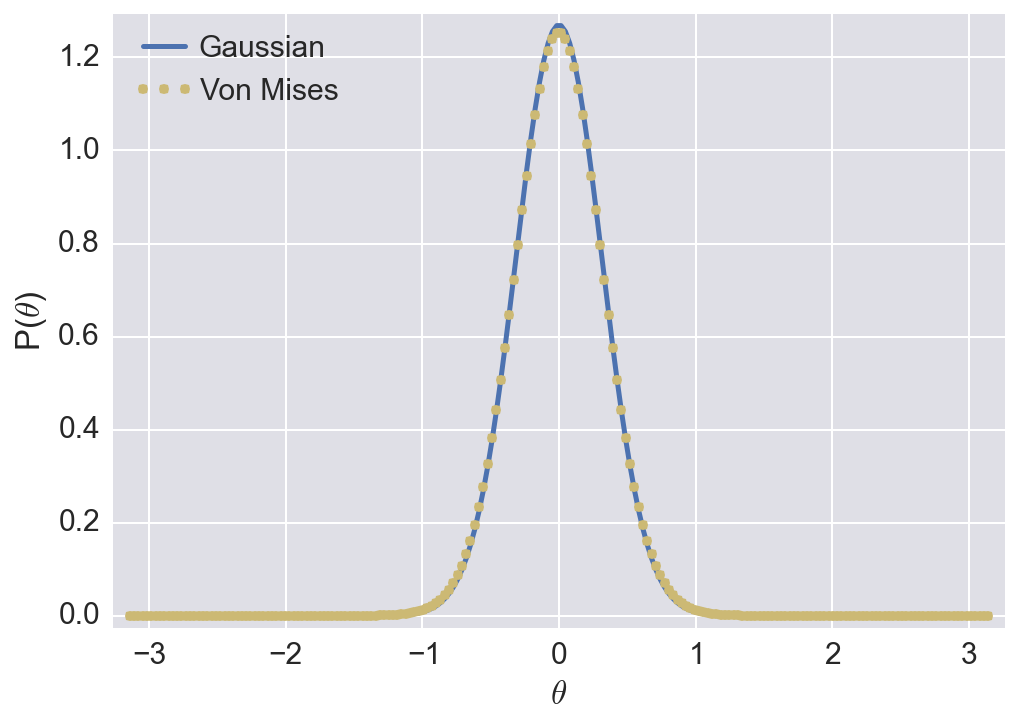

In [11]:
# Set up x for plotting
x = np.linspace(-np.pi, np.pi, 200)

# Set sigma to 1/20 of total domain size
sigma = np.pi / 10.0

# Compute Von Mises and Gaussian
beta = 1.0 / sigma**2
von_mises = st.vonmises.pdf(x, beta)
gaussian = st.norm.pdf(x, scale=sigma)

# Plot the results
plt.plot(x, gaussian, '-', label='Gaussian')
plt.plot(x, von_mises, '.', markersize=10, 
         color=sns.color_palette()[4], label='Von Mises')
plt.margins(0.02)
plt.xlabel(r'$\theta$')
plt.ylabel(r'P($\theta$)')
plt.legend(loc='upper left', numpoints=3)

The Gaussian function has a peak and has a familiar parameter, $\sigma$ that nicely summarizes its width.  So, it is naturally a good choice.  Of course, it needs to be unnormalized and have a background added (as that describes the data).  It is important not to confuse ourselves here.  We should perhaps call the above equation our "peak equation," avoiding use of the term "Gaussian."  We are not implying that the fluorescent intensity if somehow Gaussian distributed in space.  It is merely peaked, and this functional form is a convenient way to describe the peak.

So, we will follow the paper and use a Gaussian plus background to fit the data.  (Note: the authors were aware of the periodicity issue and commented on it in their paper; they were being careful!)  The standard deviation can then be a metric for gradient width.  The equation is

\begin{align}
F(x; a, b, \mu, \sigma) = a + b \exp\left\{-\frac{(x - \mu)^2}{2\sigma^2}\right\},
\end{align}

where $a$ is the background, $b$ sets the arbitrary scale of the $y$-axis, $\mu$ is the location of the center of the peak, and $\sigma$ describes the width of the peak.  We use $F$ to stand for fluorescence intensity.

**b)** In our regression, we will assume that each nucleus has a fluorescence intensity that is drawn from a process that gives Gaussian distributed intensities in accordance the central limit theorem.  So as not to confuse notation, we will call the (unknown) variance of this process $\sigma_F$ (we usually call it $\sigma$).

We will also assume that the parameters $a$ and $b$ are not the same from one experiment to another, possibly due to different levels of photobleaching prior to each experiment.

With all this in hand, we can write our likelihood.

\begin{align}
P(D\mid a, b, \mu, \sigma,\sigma_I, I) &= \prod_{i\in D}\frac{1}{\sqrt{2\pi\sigma_F^2}}\,
\exp\left\{-\frac{\left(F_i - F(x_i;a,b,\mu,\sigma)\right)^2}{2\sigma_F^2}\right\} \\
&= \prod_{i\in D}\frac{1}{\sqrt{2\pi\sigma_F^2}}\,
\exp\left\{-\frac{1}{2\sigma_F^2}\left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right\}
\end{align}

We will assume the five parameters are independent, so the prior is the product of their respective priors.  As usual, we will assume a Jeffreys prior on $\sigma_F$.  We will assume a uniform prior on $\mu$, noting that $-1 < \mu \le 1$.  We will also assume uniform priors on $a$ and $b$, noting that $a,b > 0$.  Finally, we will assume a uniform prior on $\sigma$.  Why not a Jeffreys prior?  A Jeffreys prior is not necessarily inappropriate, but because we are on a finite domain and $\sigma$ is describing a well-defined width of a gradient, we do not wish to enforce symmetry property of $P(\sigma < 1 \mid I) = P(\sigma > 1 \mid I)$, which is where the Jeffreys prior comes from.

We can now write the posterior.

\begin{align}
P(a,b,\mu,\sigma,\sigma_F) \propto \sigma_F^{-n-1} \,\exp\left\{-\frac{1}{2\sigma_F^2}\sum_{i\in D} \left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right\}.
\end{align}

We now marginalize over $\sigma_F$ to get a Student-t distribution, as we have seen a few times now in the tutorials.

\begin{align}
P(a,b,\mu,\sigma) \propto \left(\sum_{i\in D} \left(F_i - a - b \,\mathrm{e}^{-(x_i - \mu)^2/2\sigma^2}\right)^2\right)^{-n/2}.
\end{align}

**c)** First, we'll load and tidy the data set.

In [12]:
# Load the nuclear Venus fluorescence intensity levels into a DataFrame
df = pd.read_csv('../data/reeves_et_al/reeves_dv_profile_over_time.csv',
                 comment='#')

# Take a look
df.head()        

,DV coord nc 14,fluor intensity nc 14,DV coord nc 13,fluor intensity nc 13,DV coord nc 12,fluor intensity nc 12,DV coord nc 11,fluor intensity nc 11
0,0.7813,1.6512,0.7939,1.6763,0.9210,1.0523,0.9347,1.2730
1,0.8565,1.4200,0.8404,1.1663,-0.5801,1.4345,-0.9663,1.1778
2,0.8986,1.3845,0.8789,1.3919,-0.5192,1.2087,-0.5628,1.2967
3,0.9286,1.3960,0.9879,1.2993,-0.4795,1.2272,-0.3528,1.4155
4,-0.9356,1.1741,-0.9231,1.2076,-0.3491,1.4272,-0.1478,2.0224


We'll create a `MultiIndex` for the column headings and then melt the `DataFrame`.

In [13]:
# Make MultiIndex
level_0 = [int(col[-2:]) for col in df.columns]
level_1 = [col[:col.find(' nc')] for col in df.columns]
df.columns = pd.MultiIndex.from_tuples(list(zip(level_0, level_1)),
                                       names=['nuclear cycle', 'variable'])

# Make tidy df
df_tidy = pd.DataFrame(columns=['nuclear cycle', 'DV coord', 'fluor intensity'])
for nuc_cycle in df.columns.get_level_values('nuclear cycle'):
    df_add = df[nuc_cycle].dropna()
    df_add['nuclear cycle'] = pd.Series([nuc_cycle] * len(df_add),
                                        index=df_add.index)
    df_tidy = df_tidy.append(df_add, ignore_index=True)
    
# Make sure nuclear cycle is int
df_tidy['nuclear cycle'] = df_tidy['nuclear cycle'].astype(int)

# Take a look
df_tidy.head()

,DV coord,fluor intensity,nuclear cycle
0,0.7813,1.6512,14
1,0.8565,1.4200,14
2,0.8986,1.3845,14
3,0.9286,1.3960,14
4,-0.9356,1.1741,14


Great!  We now have a tidy `DataFrame`!

Since we will perform many regressions, I will write a few functions to perform the regressions.

In [14]:
def peak(p, x):
    """
    Theroetical peak (Gaussian + bg)
    """
    a, b, mu, sigma = p
    return a + b * np.exp(-(x - mu)**2 / 2 / sigma**2)


def resid(p, x, f):
    """
    Residuals for peak fitting.
    """
    return f - peak(p, x)


def log_post(p, x, f):
    """
    Log of the posterior.
    """
    return -len(x) / 2 * np.log(np.sum(resid(p, x, f)**2))


def covariance(popt, x, f):
    """
    Compute covariance matrix at popt.
    """
    # Use "complex" method, more accurate if we have all analytic functions.
    hes_fun = ndt.Hessian(log_post, method='complex')
    return -np.linalg.inv(hes_fun(popt, x, f))
  
    
def fit_model(df, nuc_cycle, print_results=False):
    """
    Perform regression on nuclear cycle.
    """
    # Extract data
    inds = (df['nuclear cycle'] == nuc_cycle)
    x = df[inds]['DV coord']
    f = df[inds]['fluor intensity']
    
    # Initial guess
    a = 1.0
    b = 5.0
    mu = 0.0
    sigma = 0.5
    p0 = np.array([a, b, mu, sigma])
    
    # Get most probable parameter values
    args = (x, f)
    popt, _= scipy.optimize.leastsq(resid, p0, args=args)

    # Get covariance matrix
    cov = covariance(popt, x, f)
    
    # Compute errors
    a_err, b_err, mu_err, sigma_err = np.sqrt(np.diag(cov))

    # Report results
    if print_results:
        print("""\n\nMost probable parameter values for nuclear cycle {8:d}:
        a =     {0:.3f} += {4:.3f}
        b =     {1:.3f} += {5:.3f}
        mu =    {2:.3f} += {6:.3f}
        sigma = {3:.3f} += {7:.3f}""".format(
                        popt[0], popt[1], popt[2], popt[3], 
                        a_err, b_err, mu_err, sigma_err, nuc_cycle))
    
    # Return optimizal parameters and covariance matrix
    return popt, cov


def fit_all_models(df, print_results=False):
    """
    Find widths of all nuclear cycles.
    """
    results = {}
    for nuc_cycle in sorted(df_tidy['nuclear cycle'].unique()):
        popt, cov = fit_model(df_tidy, nuc_cycle, print_results=print_results)
        results[nuc_cycle] = {'popt': popt, 'cov': cov}
    
    return results

Now, we'll fit each data set and determine the widths.

In [15]:
fit_results = fit_all_models(df_tidy, print_results=True)



Most probable parameter values for nuclear cycle 11:
        a =     1.324 += 0.037
        b =     1.505 += 0.090
        mu =    0.011 += 0.008
        sigma = 0.149 += 0.013


Most probable parameter values for nuclear cycle 12:
        a =     1.247 += 0.069
        b =     2.828 += 0.139
        mu =    -0.000 += 0.007
        sigma = 0.152 += 0.010


Most probable parameter values for nuclear cycle 13:
        a =     1.280 += 0.027
        b =     3.249 += 0.057
        mu =    -0.003 += 0.003
        sigma = 0.158 += 0.004


Most probable parameter values for nuclear cycle 14:
        a =     1.243 += 0.033
        b =     4.297 += 0.078
        mu =    -0.011 += 0.003
        sigma = 0.162 += 0.004


We can now plot the most probable curves along with the data.

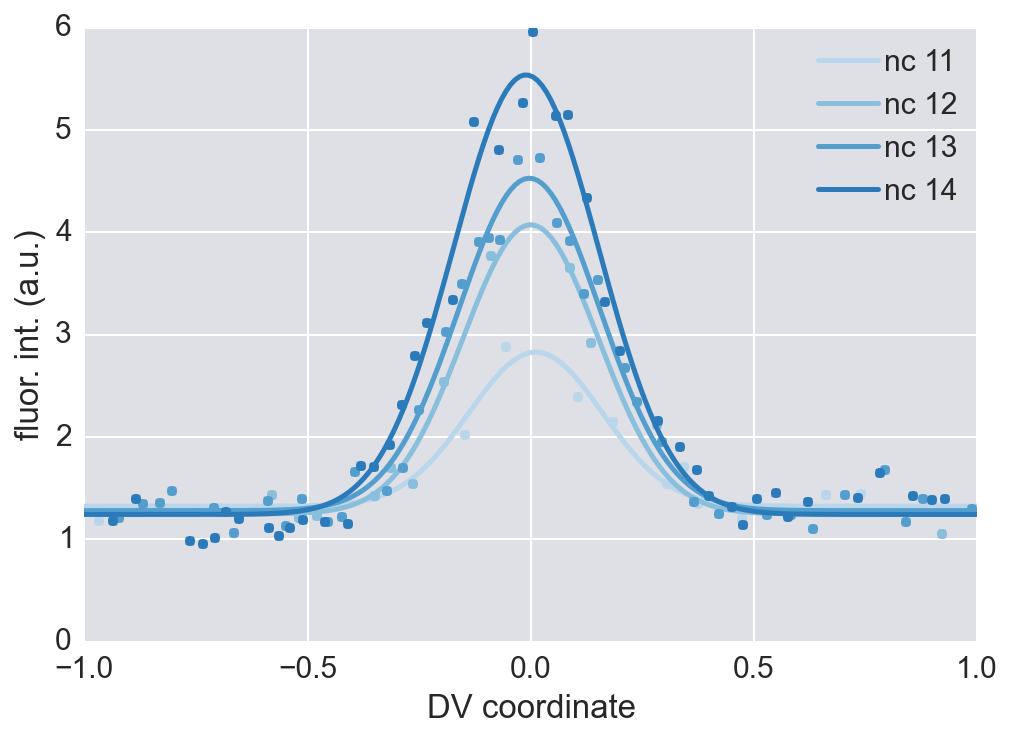

In [16]:
# Smooth curve x
x_smooth = np.linspace(-1, 1, 200)

# Colors for plot
colors = sns.color_palette('Blues', 6)[1:-1]

# Generate plot for each nuclear cycle
for i, nuc_cycle in enumerate(sorted(df_tidy['nuclear cycle'].unique())):
    # Label
    label = 'nc ' + str(nuc_cycle)

    # Plot smooth curve
    plt.plot(x_smooth, peak(fit_results[nuc_cycle]['popt'], x_smooth), '-', 
             color=colors[i], label=label)
    
    # Generate plot of points
    inds = (df_tidy['nuclear cycle'] == nuc_cycle)
    x = df_tidy[inds]['DV coord']
    f = df_tidy[inds]['fluor intensity']
    plt.plot(x, f, '.', markersize=10, color=colors[i])
    
# Label axes
plt.xlabel('DV coordinate')
plt.ylabel('fluor. int. (a.u.)')
    
# Add legend
plt.legend()

The location of the peak is similar, and the width of the gradient seems to grow slightly over time.  We can plot it to see how strong the effect is.

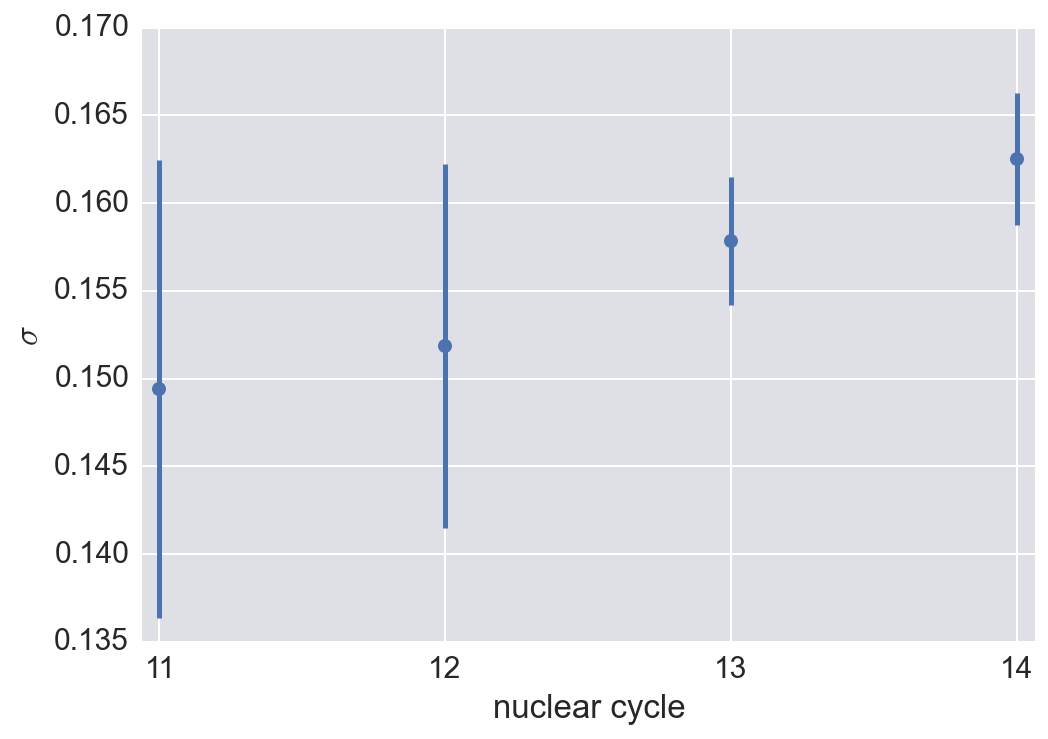

In [17]:
# Plot each gradient width with error bar
for nuc_cycle in df_tidy['nuclear cycle'].unique():
    plt.errorbar(nuc_cycle, fit_results[nuc_cycle]['popt'][-1],
                 yerr=np.sqrt(fit_results[nuc_cycle]['cov'][-1,-1]), marker='o', 
                 color=sns.color_palette()[0])

# Clean up plot
plt.margins(x=0.02)
plt.xlabel('nuclear cycle')
plt.ylabel(r'$\sigma$')
plt.xticks(list(sorted(df_tidy['nuclear cycle'].unique())));

So, the effect is not strong compared to the error in determination of the gradient width $\sigma$.

**d)** The easiest and most complete way to look at these data is to generate a strip plot (a.k.a. a jitter plot).  This is easily accomplished using Seaborn with a tidy `DataFrame`.  For ease of comparison, we will lay the strip plot over a box plot.

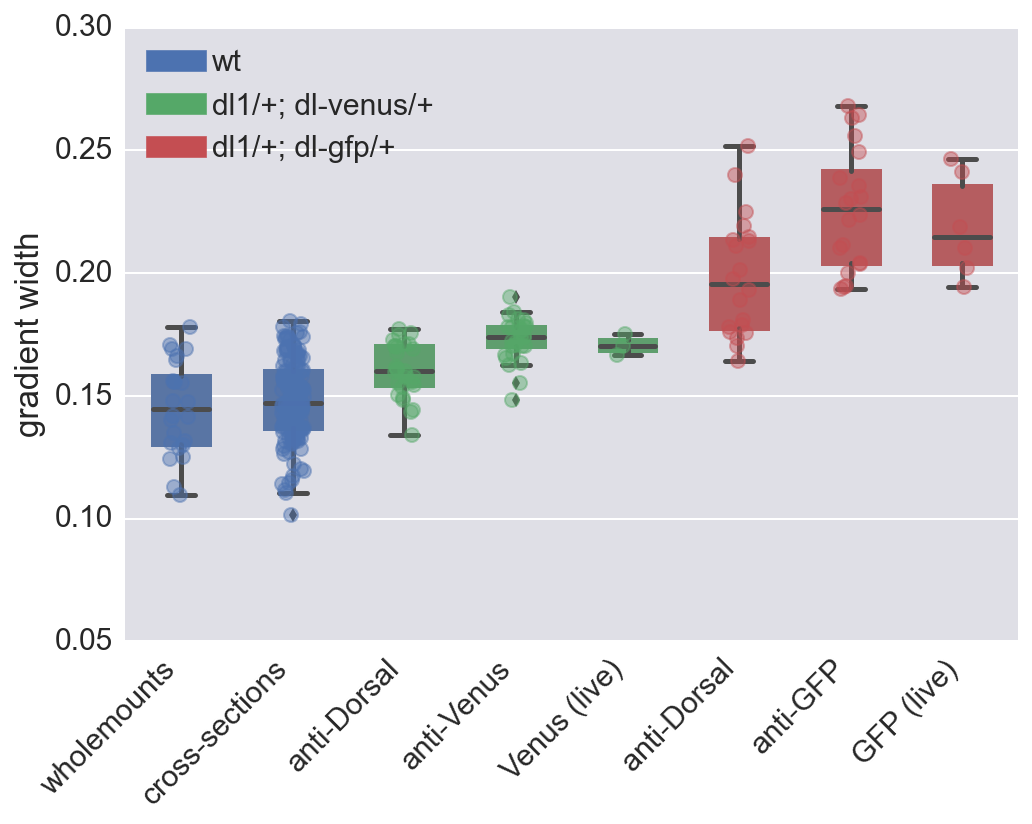

In [18]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#', header=[0, 1])

# Get genotypes
genotypes = list(df.columns.get_level_values(0))
unique_gtypes = df.columns.get_level_values(0).unique()

# Make color key for boxes
color_key = {}
for i, gtype in enumerate(unique_gtypes):
    color_key[gtype] = sns.color_palette()[i]
    
# Make colors for boxes/points
colors = [color_key[gtype] for gtype in genotypes]

# For x-labels, we only care about imaging method, so reset columns
df.columns = df.columns.get_level_values(1)

# Rename duplicate columns
col_count = dict([(col, 0) for col in df.columns.unique()])
cols = list(df.columns)
for i, col in enumerate(df.columns):
    cols[i] = ' '*col_count[col] + col
    col_count[col] += 1
df.columns = cols

# Tidy it
df = pd.melt(df, var_name='genotype', value_name='gradient width')
df = df.dropna()

# Make a strip plot
sns.boxplot(data=df, x='genotype', y='gradient width', width=0.5, palette=colors)
sns.stripplot(data=df, x='genotype', y='gradient width', jitter=True,
              edgecolor='w', alpha=0.45, palette=colors)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, 
         horizontalalignment='right')
plt.xlabel('')

# Make legend with custom patches
patches = [matplotlib.patches.Patch(color=color_key[gtype], label=gtype) \
               for gtype in unique_gtypes]
plt.legend(handles=patches, loc='upper left');

The Venus samples have gradient widths that are consistently higher than the average of the wild type mounts.  Nonetheless, they all fall within the higher range of gradient widths that we see with wild type mounts.  The GFP samples, however, show consistently higher gradient widths.  They do not rescue the *dorsal* deficiency, so that are not very useful anyhow.

<br />

### Problem 3.3: HIV clearance and a warning about regressions (20 pts extra credit)

A human immunodeficiency virus (HIV) is a virus that causes host organisms to develop a weaker, and sometimes ineffective, immune system. HIV inserts its viral RNA into a target cell of the immune system.  This virus gets reverse transcribed into DNA and integrated into the host cell's chromosomes.  The host cell will then transcribe the integrated DNA into mRNA for the production of viral proteins and produce new HIV.  Newly created viruses then exit the cell by budding off from the host.  HIV carries the danger of ongoing replication and cell infection without termination or immunological control.  Because CD4 T cells, which communicate with other immune cells to activate responses to foreign pathogens, are the targets for viral infection and production, their infection leads to reductions in healthy CD4 T cell production, causing the immune system to weaken.  This reduction in the immune response becomes particularly concerning after remaining infected for longer periods of time, leading to acquired immune deficiency syndrome (AIDS).

Perelson and coworkers have developed mathematical models to study HIV populations in the eukaryotic organisms.  HIV-1 will infect cells at a rate $k$ and is produced from these infected T cells at a rate $p$.  On the other hand, the viruses are lost due to clearance by the immune system of drugs, which occurs at a rate $c$, and infected cells die at a rate $\delta$ (Figure from [Perelson, *Nat. Rev. Immunol.*, **2**, 28-36, 2002](../protected/paper/perel_son2002.pdf))

![/Basic model of viral infection](hiv_figure.jpg "Basic model of viral infection Perelson Nat. Rev. Immunol. 2002)")

The above process can be written down as a system of differential equations.

\begin{align}
\frac{dT^*}{dt} &= k V_I T - \delta T^*\\[1em]
\frac{dV_I}{dt} &= -cV_I\\[1em]
\frac{dV_{NI}}{dt} &= N \delta T^{*} - c V_{NI},
\end{align}

Here, $T(t)$ is the number of uninfected T-cells at time $t$, and $T^*$ is the number of infected T cells. Furthermore, there is a concentration $V_I(t)$ of infectious viruses that infect T cells at the rate $k$.  We also have a concentration $V_{NI}$ of innocuous viruses. We define $N(t)$ to be the number of newly produced viruses from one infected cell over this cell's lifetime.  We can measure the total viral load, $V(t) = V_I(t) + V_{NI}(t)$.  If we initially have a viral load of $V(0) = V_0$, we can solve the system of differential equations to give

\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right].
\end{align}

We will take viral load data from a real patient (which you can download [here](../data/hiv_data/csv)) and perform a regression to evaluate the parameters $c$ and $\delta$.  The drug Ritonavir is a protease inhibitor that serves to clear the viruses; i.e., it modulates $c$. So, $c$ is a good parameter to use to understand the efficacy of a drug.

**a)** Perform a regression on these data using the theoretical temporal curve for the viral load.

**b)** Plot the posterior distribution over the interval $0 \le \delta, c \le 10$ days$^{-1}$.  Does this plot raise any serious issues about how you estimate $c$ and $d$?  What experiments might you propose to help deal with these problems?

### Problem 3.3: solutions
**a)** In fitting the viral load model, we need to make sure that we don't get a divide by zero error when $c \approx \delta$.  We will use the fact that

\begin{align}
\lim_{c\to\delta} V(t) = V_0 \left(1 + \delta t + \frac{\delta^2 t^2}{2}\right)\mathrm{e}^{-\delta t}.
\end{align}

We can now write our viral load model.  Because we will be computing the posterior on a grid for plotting later, I am going to use Numba to speed things up.  We will talk about Numba later in the class as we dive more into MCMC.

In [19]:
@numba.jit(nopython=True)
def viral_load_model(p, t):
    """Perelman model for viral load"""
    # Unpack parameters
    V_0, c, delta = p
            
    # If c and d are close, use limiting expression
    if abs(c - delta) < 1e-9:
        return V_0 * (1 + delta * t +  (delta * t)**2 / 2) * np.exp(-delta * t)

    # Proceed with typical calculation
    bracket_term = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) \
                                        - delta * t * np.exp(-c * t)

    return V_0 * (np.exp(-c * t) + c / (c - delta) * bracket_term)

When we perform our regression to find the MAP, it will be useful to employ the trick where we use logarithms of the parameters.

In [20]:
@numba.jit(nopython=True)
def viral_load_model_log_params(p, t):
    """Viral load model given by Perelson et al. with log parameters"""
    return viral_load_model(np.exp(p), t)

We can now code up our residual function and log posterior, which we need to find the MAP and error bars, respectively.  The posterior, as we have derived before, is a Student-t distribution, since we marginalize out the unknown variance in the measurements.

In [21]:
@numba.jit(nopython=True)
def resid(p, t, V):
    """Residuals for viral load model with log parameters."""
    return V - viral_load_model_log_params(p, t)


@numba.jit(nopython=True)
def log_posterior(p, t, V):
    """Log posterior for viral load model."""
    return -len(t) / 2 * np.log(np.sum(resid(np.log(p), t, V)**2))

To get the initial guess, we'll load and plot the data.  $V_0$ will approximately be the viral load at $t = 0$.

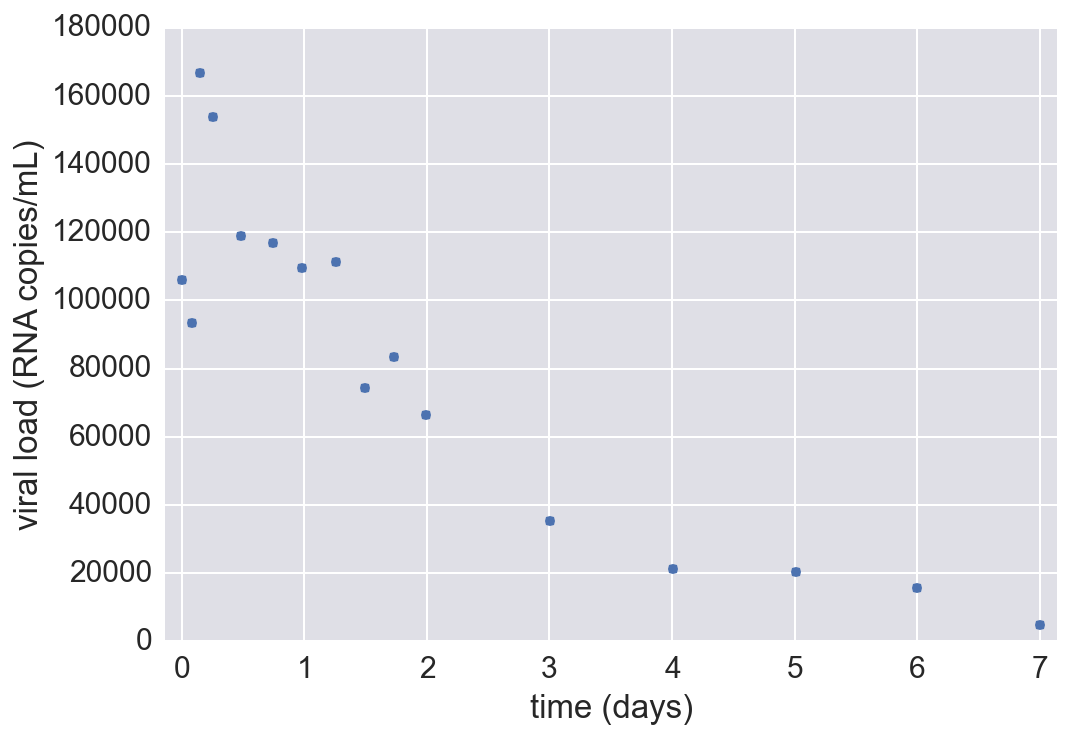

In [22]:
# Load data set using Pandas
df = pd.read_csv('../data/hiv_data.csv', comment='#')

# Plot the data
plt.plot(df['Days after administration'], df['RNA copies per mL'], '.', 
         markersize=10)
plt.margins(x=0.02)
plt.xlabel('time (days)')
plt.ylabel('viral load (RNA copies/mL)')

So, we will guess $V_0 \approx 150000$ RNA copies/mL.  We'll guess that $c$ is dominating the drop in load and choose $c \approx 3$ days$^{-1}$.  We'll guess $\delta$ is slower, say 0.3 day$^{-l}$.  We'll perform the curve fit and compute the covariance.


V_0 = 1.29e+05 ± 7.44e+03 copies of RNA/mL
  c = 2.64 ± 1.56 1/days
  δ = 0.53 ± 0.19 1/days



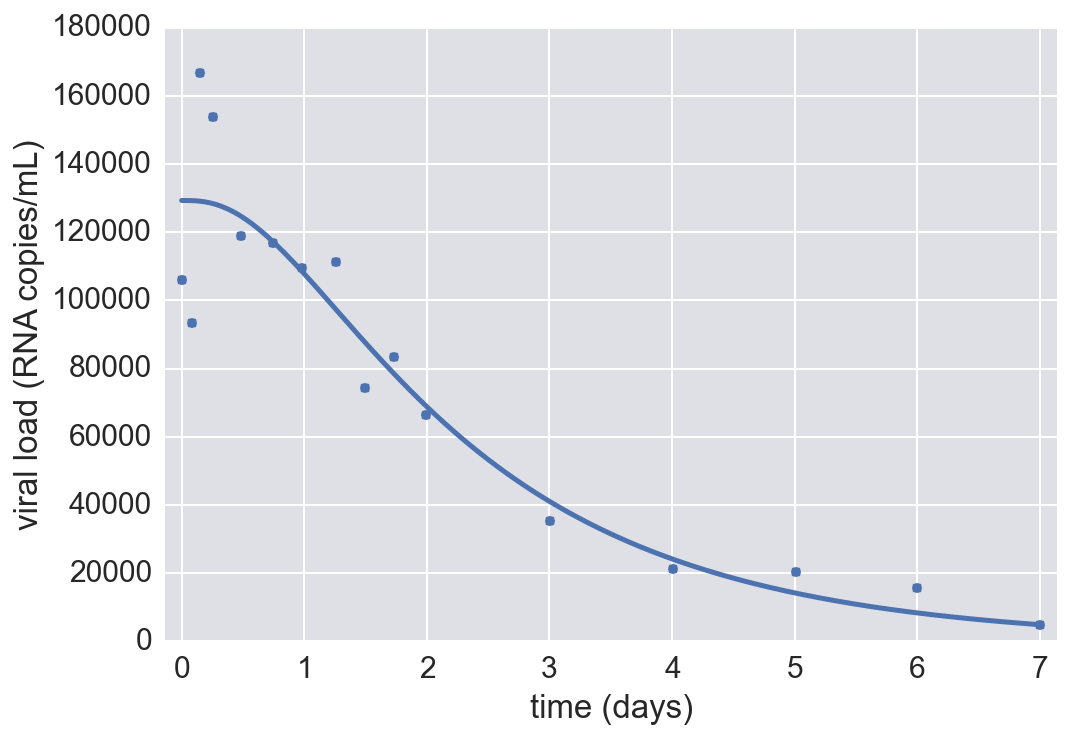

In [23]:
# Initial guess
log_p0 = np.log(np.array([150000, 3, 0.3]))

# Find MAP
args = (df['Days after administration'].values, df['RNA copies per mL'].values)
log_popt, _ = scipy.optimize.leastsq(resid, log_p0, args=args)
popt = np.exp(log_popt)

# Approximate as Gaussian and compute covariance
hes_fun = ndt.Hessian(log_posterior, method='complex')
cov = -np.linalg.inv(hes_fun(popt, *args))
err_bars = np.sqrt(np.diag(cov))

# Print results to screen
print("""
V_0 = {0:.2e} ± {1:.2e} copies of RNA/mL
  c = {2:.2f} ± {3:.2f} 1/days
  δ = {4:.2f} ± {5:.2f} 1/days
""".format(popt[0], err_bars[0], popt[1], err_bars[1], popt[2], err_bars[2]))

# Plot the regresion
t_smooth = np.linspace(0, 7, 200)
plt.plot(t_smooth, viral_load_model(popt, t_smooth), '-')
plt.plot(df['Days after administration'], df['RNA copies per mL'], '.', 
         markersize=10, color=sns.color_palette()[0])
plt.margins(x=0.02)
plt.xlabel('time (days)')
plt.ylabel('viral load (RNA copies/mL)')

We have managed to find the MAP and give error bars based on the Gaussian approximation.  Great!  Now, for a sanity check, let's plot the posterior.

**b)** We want to make a contour plot in the $c$-$\delta$ plane, so we need to marginalize over $V_0$.  We will do this numerically, using `np.trapz()`.

In [24]:
# Values of c, delta, and V_0 to consider
c_plot = np.linspace(0, 10, 301)
delta_plot = np.linspace(0, 10, 300)
V_0_plot = np.linspace(6e4, 1.8e5, 99)
cc, dd, VV = np.meshgrid(c_plot, delta_plot, V_0_plot, indexing='ij')

# Pull out data
t = df['Days after administration'].values
V = df['RNA copies per mL'].values

# Compute log of the posterior
@numba.jit()
def compute_log_post(c_plot, delta_plot, V_0_plot, cc, t, V):
    log_post = np.empty_like(cc)
    for i, c in enumerate(c_plot):
        for j, d in enumerate(delta_plot):
            for k, V_0 in enumerate(V_0_plot):
                p = np.array([V_0, c, d])
                log_post[i, j, k] = log_posterior(p, t, V)
    return log_post - log_post.max()

# Compute log posterior
log_post = compute_log_post(c_plot, delta_plot, V_0_plot, cc, t, V)

# Marginalize
post_marg = np.trapz(np.exp(log_post), x=V_0_plot, axis=2)

Now that we have computed the marginalized posterior, we can plot it.  I include the location of the MAP as found from optimization.

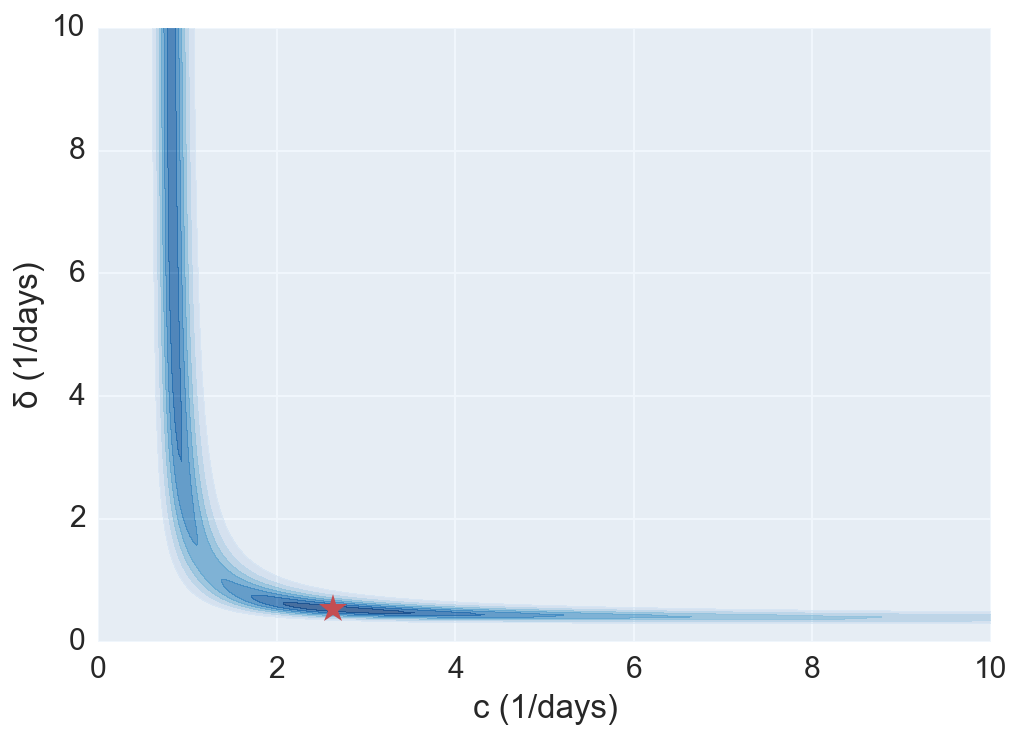

In [25]:
# Plot the contour
plt.contourf(cc[:,:,0], dd[:,:,0], post_marg, cmap=plt.cm.Blues, alpha=0.7)
plt.plot(popt[1], popt[2], '*', markersize=15, color=sns.color_palette()[2])
plt.xlabel('c (1/days)')
plt.ylabel('δ (1/days)')

Wow!  The posterior has an odd shape; it is very far from Gaussian.  The long, stretched contour implies that for a given los value of $\delta$, $c$ may take on a wide range of values.  We saw this due to the high error bar in $c$ from our regression.  Note also that the posterior is bimodal.  It has another long, narrow peak for small $c$, meaning that $\delta$ could take most any value.

To deal with this issue, we should independently measure $\delta$ to get an informative prior for it, which would then qualitatively change the posterior and enable better estimation of $c$.

<br />

### Problem 3.4 Connections in the human brain (40 pts extra credit)
Julien Dubois presented his research to us on Wednesday.  You should have been able to download the data sets for this homework via Caltech Dropbox.  Upon unzipping the ZIP file, you will have the following files that came from Subject 1 of their study.

* `SUB01_data.csv`: Each column corresponds to a given time point.  Scans were taken at 1 Hz, so column 0 is time zero, column 1 is 1 second, column 2 is two seconds, and so on.  Each row is a given grayordinate, or coordinate in space.
* `SUB01_uncleaned_data.csv`: The same as `SUB01_data.csv`, except without the  filtering and cleaning preprocessing that Julien talked about on Wednesday.
* `SUB01_region.csv`: The entry in row $i$ is the region ID for grayordinate $i$ in Subject 1.  In other words, row $i$ of the `SUB01_data.csv` file described the grayordinate whose ID is given in row $i$ of `SUB01_region.csv`.
* `regionkey.csv`: Column 0 contains the region ID and column 1 contains a string with the name of the region for that ID.  I.e., region 1015 is `L_G_front_middle`, signifying the left frontal middle gyrus.

Your task is to compute and display the matrix that Julien showed in lecture.  Specifically, you need to do the following steps.

1. Load in the data into a convenient, ideally tidy, format for you to work with.
2. Group the grayordinate by the regions they belong to in the brain, as per the information in the `SUB01_region.csv` file.
3. Compute the mean activity for each region for each time point.
4. Compute the Pearson correlation coefficient (see below) for each pair of regions.
5. Display the result as a color-coded matrix.  Entry $i,j$ in this matrix is color-coded according to the Pearson correlation coefficient between region $i$ and region $j$.  As Julien said, this matrix is symmetric.  Plotting this is much more informative if it is interactive.  You may wish to use the `bokeh_matplot()` function in the [BE/Bi 103 Python utilities](https://github.com/justinbois/bebi103_utils).

Comment on any interesting patterns or observations you notice in the correlation matrix.

After you do this for the `SUB01_data.csv` date set, repeat the analysis for the `SUB01_uncleaned_data.csv` set.  Do you see qualitative differences in the correlation matrix between the clean and uncleaned data?

Below, we give some background on the Pearson correlation coefficient.  Be sure to address the question at the very end of this problem statement.

#### Background on the Pearson correlation coefficient

Before you proceed, I wanted to give a little background on the Pearson correlation coefficient.  Imagine I have to sets of measurements, $\mathbf{x}$ and $\mathbf{y}$, from the same subject.  An example measurement pair would be $x_i = $ beak depth and $y_i = $ beak length for a given finch.  In our case, an example would be $x_i = $ the mean fMRI signal in the left amygdala at a given time point and $y_i = $ the mean fMRI signal in the right hippocampus at the same time point.

Now, assume a model that the measurements are possibly correlated, and are drawn from a Gaussian distribution.  If we make $n$ total measurments, the posterior is

\begin{align}
P(\mu, \sigma^2 \mid \mathbf{x}, \mathbf{y}, I) \propto \left(\frac{1}{\sqrt{\det \sigma^2}}\right)^n \,\exp\left[
-\frac{1}{2}\sum_{i\in D}\begin{pmatrix}x_i - \mu_x\\y_i-\mu_y\end{pmatrix}^\mathsf{T} \cdot
\left(\sigma^2\right)^{-1} \cdot \begin{pmatrix}x_i - \mu_x\\y_i-\mu_y\end{pmatrix}
\right],
\end{align}

where we have for simplicity assumed a uniform prior.  We have defined $\mu = (\mu_x, \mu_y)^\mathsf{T}$ to be vector valued, and we have defined the **covariance matrix** as

\begin{align}
\sigma^2 = \begin{pmatrix}
\sigma_x^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_y^2
\end{pmatrix}.
\end{align}

The diagonal entries are the variances in $x$ and $y$ alone, and $\sigma_{xy}$ is the covariance.  The stronger the correlation between $x$ and $y$, the larger the magnitude of the covariance.  For example, if we observe that the data closely follow $y = x$, $\sigma_{xy}$ is large and positive.  Conversely, if $y = -x$, the covariance is of large magnitude and negative.

The **Pearson correlation coefficient**, $\rho$, is defined as

\begin{align}
\rho = \frac{\sigma_{xy}}{\sigma_x \sigma_y}.
\end{align}

This weights the effects of the covariance with the variance in each variable.  In this way, $-1\le\rho\le 1$, and $\rho$ provides a good metric of how $x$ and $y$ are related, regardless of noise.

We can show that the most probable Pearson correlation coefficient is that given directly by computing the sample covariances.

\begin{align}
\rho^* = \frac{\sum_{i\in D}\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)}{\sqrt{\left(\sum_{i\in D} \left(x_i - \bar{x}\right)^2\right)\left(\sum_{i\in D} \left(y_i - \bar{y}\right)^2\right)}}.
\end{align}

The function `scipy.stats.pearsonr()` does this for us.  As an example, we will draw samples out of a bivariate Gaussian distribution and plot them.

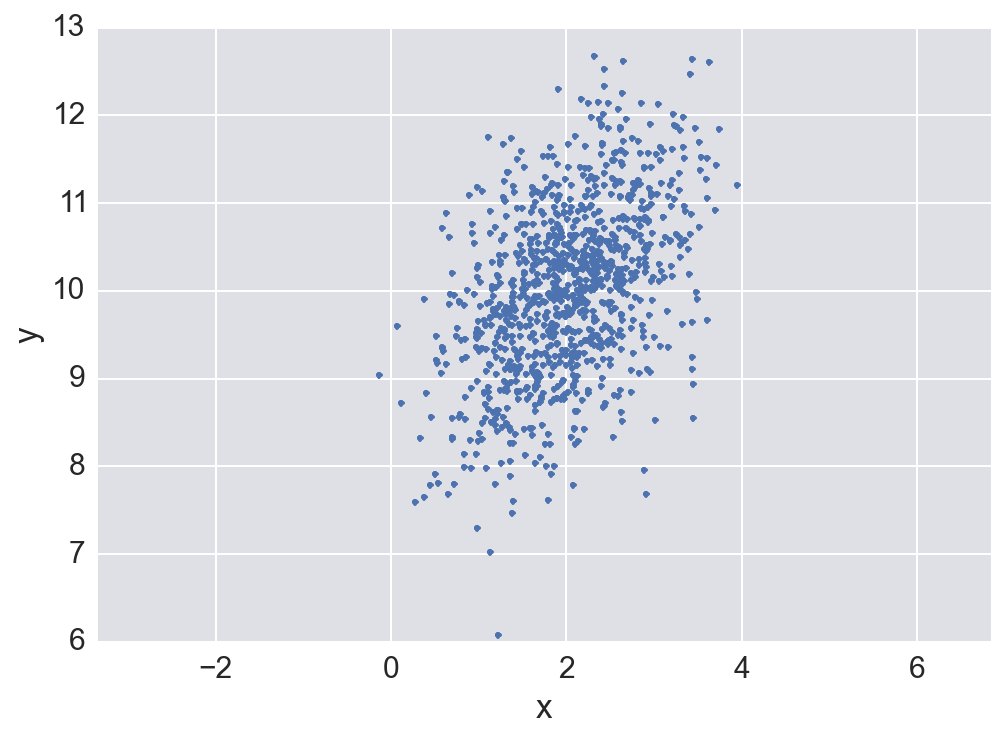

In [26]:
# Specify means and covariance matrix (small, positive covariance)
mu = np.array([2, 10])
cov = np.array([[0.5, 0.3],[0.3, 0.9]])

# Draw 1000 samples
x, y = np.random.multivariate_normal(mu, cov, 1000).T
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');

We see that the data are correlated in that that the cloud of point is rotated rightward, but only slightly correlated because the data are still fairly isotropic.  The expected Pearson correlation coefficient is $\rho = 0.3 / \sqrt{0.5 \cdot 0.9} \approx 0.45$.  Let's see what we get by computing $\rho$ directly from the samples.

In [27]:
st.pearsonr(x, y)

(0.45332455117540221, 7.7658970765060107e-52)

The first entry is what matters (since `scipy.stats.pearsonr()` returns two values, the first being the actual Pearson correlation coefficient).  Now, if we have a larger, negative Pearson correlation coefficient, we have qualitatively different looking data.

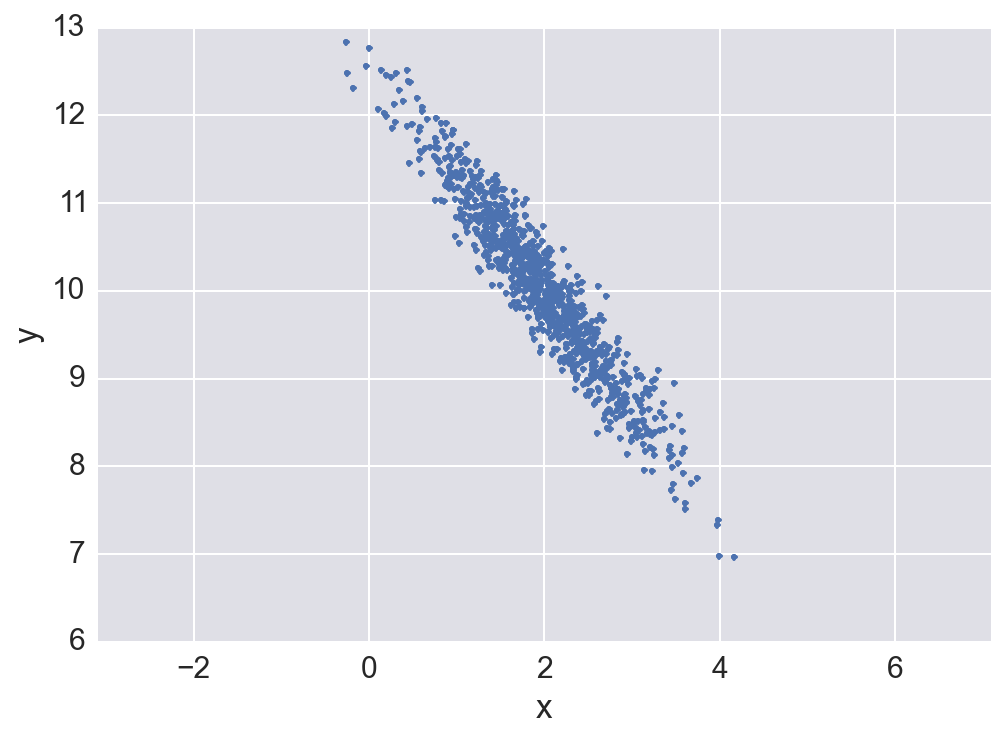

In [28]:
# Specify means and covariance matrix (small, positive covariance)
mu = np.array([2, 10])
cov = np.array([[0.5, -0.64],[-0.64, 0.9]])

# Draw 1000 samples
x, y = np.random.multivariate_normal(mu, cov, 1000).T
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');

Now, the data are much more strongly (negatively) correlated.  We can compute the Pearson correlation coefficient.

In [29]:
print('       Exact:', -0.64 / np.sqrt(0.5 * 0.9))
print('From samples:', scipy.stats.pearsonr(x, y)[0])

       Exact: -0.9540556704
From samples: -0.952355812492


**Question**: Do you see any possible problems with using the Pearson correlation coefficient for these time series data?

### Problem 3.4: solution
Because we will work with many files of these data, we will write a function to load in the information and return a tidy `DataFrame`.

We start by loading in the metadata describing the regions for each of the grayordinates in the main data file.  We load them in as Pandas `Series` objects because they are easier to index (no need to specify a column name).  We do this by using the `pd.read_csv()` function to read into a `DataFrame`, and then just slice out the `Series` we want.

Then, we'll load the main data set.  We will use `pd.melt()` to put it in tidy format.  Here is our strategy

1. Compute the time points, knowing that each column in the `DataFrame` holds a single time point, and that the elapsed time between samples is one second.
2. Make the time points the column names.
3. Concatenate the region index onto the `DataFrame`.
4. Concatenate the region string onto the `DataFrame`.
5. Melt the `DataFrame`.

In [30]:
def tidy_fmri(data_fname, regions_fname, region_key_fname, frame_rate):
    """
    Load in fMRI data and return a tidy DataFrame with labeled
    grayordinates.
    """

    # Load in the key that relates brain region to identifies
    s_region_keys = pd.read_csv(region_key_fname, header=None, 
                                names=['region_name'], 
                                index_col=0)['region_name']

    # Load in regions corresponding to each row of big data set
    s_regions = pd.read_csv(regions_fname, header=None, 
                            names=['region_id'])['region_id']
    
    # Read in big data set
    df = pd.read_csv(data_fname, header=None)

    # Number of frames (equal to number of columns)
    n_frames = len(df.columns)

    # Compute time points of images
    t = np.linspace(0.0, (n_frames - 1) / frame_rate, n_frames)

    # Make the time points into the column names
    df.columns = t

    # Put in the region index
    df['region_id'] = s_regions

    # Add region names
    reg_list = [s_region_keys[region] for region in s_regions]
    df['region_name'] = reg_list

    # The index iS the grayordinate; keep them
    df['grayordinate'] = df.index

    # Melt the DataFrame
    return pd.melt(df, id_vars=['region_id', 'region_name', 'grayordinate'], 
                   var_name='time (s)', value_name='voxel_value')

We'll now get our data for this problem.

In [31]:
# Frame rate
frame_rate = 1.0  # frames per second

# Specify files
regions_fname = '../data/dubois_et_al/hw3_fmri_data/SUB01_region.csv'
region_key_fname = '../data/dubois_et_al/hw3_fmri_data/regionkey.csv'
data_fname = '../data/dubois_et_al/hw3_fmri_data/SUB01_data.csv'

# Get tidy DataFrame
df = tidy_fmri(data_fname, regions_fname, region_key_fname, frame_rate)

# Take a look
df.tail()

,region_id,region_name,grayordinate,time (s),voxel_value
36512795,21,CIFTI_STRUCTURE_THALAMUS_RIGHT,91277,399,0.52
36512796,21,CIFTI_STRUCTURE_THALAMUS_RIGHT,91278,399,0.02
36512797,21,CIFTI_STRUCTURE_THALAMUS_RIGHT,91279,399,0.34
36512798,21,CIFTI_STRUCTURE_THALAMUS_RIGHT,91280,399,-3.79
36512799,21,CIFTI_STRUCTURE_THALAMUS_RIGHT,91281,399,-1.61


We now have a tidy `DataFrame` (with 36 million rows)!  We could write it out to a CSV file for later use, but this file will be large and take a longer time to read in.  Because the melt operations are fast, we can just tidy the `DataFrame` each time we load it in using our function.

Now that we have a nice, tidy `DataFrame`, we could look at our data in all sorts of creative ways.  (I hope you do!).  For now, we will proceed with the task at hand and compute the mean activity in each brain region (each of which contain many grayorinates) at each time point.  We will write a function to do it given a tidy `DataFrame` as input.  Our strategy is to do the following.
1. Group the `DataFrame` by region and time point and compute the mean at each time point.
2. Compute the Pearson correlation for each pair of regions.
3. Return a `DataFrame` containing region pairs and their Pearson correlation.

To be general and thereby enable other time series metrics (though limited to scalar metrics in this case), we will allow specification of any function comparing the mean time series of two regions.

In [32]:
def pearson_r(s1, s2):
    """
    Compute Pearson correlation coefficient between two series.
    """
    return st.pearsonr(s1, s2)[0]


def correlate(df, corr_fun=pearson_r, ignore_UNKNOWN=False, only_upper=False):
    """
    Perform correlation between pairs of grouped time series.
    """
    # Group and compute mean for each time. Keep region_id and region_name info.
    gb_names = ['region_id', 'region_name', 'time (s)']
    df_reg = df.groupby(gb_names)['voxel_value'].mean().reset_index()
    
    # Columns to consider (ignore ID 0, which is UNKNOWN, if desired)
    regs = list(df_reg['region_id'].unique())
    if ignore_UNKNOWN:
        regs.pop(0)

    # Initialize list for storing correlations
    if only_upper:
        data = [None for i in range(len(regs) * (len(regs) - 1) // 2)]
    else:
        data = [None for i in range(len(regs)**2)]
    c = 0

    # Compute pearson correlation
    for i in range(len(regs)):
        # Pull record
        r1 = regs[i]
        s1 = df_reg[df_reg['region_id']==r1]['voxel_value'].values
        r1_name = df_reg[df_reg['region_id']==r1]['region_name'].iloc[0]

        # Diagonal correlation
        if not only_upper:
            data[c] = [r1, r1, r1_name, r1_name, corr_fun(s1, s1)]
            c += 1

        # Off-diagonal correlations
        for j in range(i+1, len(regs)):
            # Pull record
            r2 = regs[j]
            s2 = df_reg[df_reg['region_id']==r2]['voxel_value'].values
            r2_name = df_reg[df_reg['region_id']==r2]['region_name'].iloc[0]
            
            # Compute correlation
            r = corr_fun(s1, s2)
            
            # Insert into matrix (symmetric)
            data[c] = [r1, r2, r1_name, r2_name, r]
            if only_upper:
                c += 1
            else:
                data[c+1] = [r2, r1, r2_name, r1_name, r]
                c += 2

    # DataFrame to hold correlations
    cols = ['region_1', 'region_2', 'region_1_name', 'region_2_name', 'corr']
    return pd.DataFrame(data, columns=cols)

Let's employ our function to build the correlations.  This will take a while (but not too long, just a few seconds) because of access of the time traces from the `groupby` object.  We could speed it up by changing the data structure, but the speed up is not sufficient to overcome the code-writing convenience of accessing tidy `DataFrame`s.

In [33]:
df_corr = correlate(df, corr_fun=pearson_r, ignore_UNKNOWN=False)

Now that we have a tidy correlation matrix, we can just plot it using Bokeh and the utility I wrote for you!  We should however, 

Because the matrix is large, we will store it as an HTML file and look at it in a separate window.  You can view the finished matrix [here](act_mat.html).

In [34]:
p = bebi103.bokeh_matplot(df_corr, 'region_1_name', 'region_2_name', 'corr', 
                          n_colors=21)
bokeh.plotting.output_file('act_mat.html')
bokeh.io.show(p)

In looking at the matrix, we see strong correlations between the same structures on the left and right hemispheres of the brain.

We can do the same analysis for the data set that has not been pre-processed.

In [35]:
# Specify file
data_fname = '../data/dubois_et_al/hw3_fmri_data/SUB01_uncleaned_data.csv'

# Get tidy DataFrame
df_unclean = tidy_fmri(data_fname, regions_fname, region_key_fname, frame_rate)

# Compute correlations
df_unclean_corr = correlate(df_unclean, corr_fun=pearson_r, ignore_UNKNOWN=False)

# Plot the result
p2 = bebi103.bokeh_matplot(df_unclean_corr, 'region_1_name', 'region_2_name', 
                           'corr', n_colors=21)
bokeh.plotting.output_file('act_mat_unclean.html')
bokeh.io.show(p2)

You can see the resulting matrix [here](act_mat_unclean.html).  We see high correlation throughout the matrix possibly because of low frequency noise in the instrument.

Finally, I comment on use of the Pearson correlation.  The most obvious flaw of this metric is that all temporal correlations are thrown away.  A more careful comparison of the time series may reveal phenomena in the data that are missed with the Pearson correlation coefficient.

Now, I will use our functions to process all of the subjects and write out tidy `DataFrame`s for each of the 55 subjects.

In [36]:
data_files = glob.glob('../data/dubois_et_al/full_dataset/*FIX*')
region_files = glob.glob('../data/dubois_et_al/full_dataset/*_region.csv')
region_key_fname = '../data/dubois_et_al/full_dataset/regionkey.csv'
frame_rate = 1.0

for i, data_fname in enumerate(data_files):
    print('Processing file %d of %d...' % (i+1, len(data_files)))
    outname = data_fname[:data_fname.find('_FIX')] + '_corr.csv'
    regions_fname = region_files[i]
    df = tidy_fmri(data_fname, regions_fname, region_key_fname, frame_rate)
    df_corr = correlate(df, corr_fun=pearson_r, ignore_UNKNOWN=True, 
                        only_upper=True)
    df_corr[['region_1', 'region_2', 'corr']].to_csv(outname, index=False)

Processing file 1 of 55...
Processing file 2 of 55...
Processing file 3 of 55...
Processing file 4 of 55...
Processing file 5 of 55...
Processing file 6 of 55...
Processing file 7 of 55...
Processing file 8 of 55...
Processing file 9 of 55...
Processing file 10 of 55...
Processing file 11 of 55...
Processing file 12 of 55...
Processing file 13 of 55...
Processing file 14 of 55...
Processing file 15 of 55...
Processing file 16 of 55...
Processing file 17 of 55...
Processing file 18 of 55...
Processing file 19 of 55...
Processing file 20 of 55...
Processing file 21 of 55...
Processing file 22 of 55...
Processing file 23 of 55...
Processing file 24 of 55...
Processing file 25 of 55...
Processing file 26 of 55...
Processing file 27 of 55...
Processing file 28 of 55...
Processing file 29 of 55...
Processing file 30 of 55...
Processing file 31 of 55...
Processing file 32 of 55...
Processing file 33 of 55...
Processing file 34 of 55...
Processing file 35 of 55...
Processing file 36 of 55...
P